In [1]:
# Install / fix dependencies
!pip install qiskit qiskit-aer \
                torch torchvision \
                scikit-learn \
                albumentations \
                torchcam lime \
                opencv-python-headless -q

In [16]:
# 2) One‐cell HQCNN pipeline with fixed LIME hook

import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, cv2
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.manifold import TSNE
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from torch.autograd import Function
from albumentations import (
    Compose, Resize, HorizontalFlip, Rotate,
    RandomBrightnessContrast, GaussianBlur, Normalize
)
from albumentations.pytorch import ToTensorV2
from torchcam.methods import SmoothGradCAMpp
from lime import lime_image

In [17]:
# Mount Drive & collect image paths
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ROOT = "/content/drive/MyDrive/original_data"

def make_dataset(root, classes=['calculus','hypodontia']):
    items, cmap = [], {c:i for i,c in enumerate(classes)}
    for fld in os.listdir(root):
        lab, p = cmap.get(fld.lower()), os.path.join(root, fld)
        if lab is None or not os.path.isdir(p): continue
        for fn in os.listdir(p):
            if fn.lower().endswith(('.jpg','jpeg','JPG')):
                items.append((os.path.join(p,fn), lab))
    return items, classes

items, CLASS_NAMES = make_dataset(ROOT)
labels = [l for _,l in items]

Mounted at /content/drive


In [18]:
# Transforms
TRAIN_AUG = Compose([
    Resize(150,150), HorizontalFlip(), Rotate(15),
    RandomBrightnessContrast(0.3,0.3), GaussianBlur((3,7)),
    Normalize((0.5,)*3,(0.5,)*3), ToTensorV2()
])
VAL_AUG = Compose([
    Resize(150,150),
    Normalize((0.5,)*3,(0.5,)*3),
    ToTensorV2()
])

class OralDS(Dataset):
    def __init__(self, items, aug):
        self.items, self.aug = items, aug
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i):
        p,l = self.items[i]
        img = plt.imread(p)
        return self.aug(image=img)['image'], torch.tensor(l, dtype=torch.long)

# 2-qubit quantum block
class QCircuit:
    def __init__(self,n=2,shots=500):
        self.n,self.shots=n,shots
        self.backend = Aer.get_backend('aer_simulator')
        self.params  = [Parameter(f'θ{i}') for i in range(n)]
        qc = QuantumCircuit(n,n)
        for i,p in enumerate(self.params): qc.ry(p,i)
        qc.cx(0,1); qc.measure_all()
        self.qc=qc
    def run(self, thetas):
        out=[]
        for vals in thetas.astype(np.float32):
            job = self.backend.run(
                self.qc.assign_parameters(dict(zip(self.params,vals))),
                shots=self.shots
            )
            c = job.result().get_counts()
            p0 = c.get('0'*self.n,0)/self.shots
            p1 = c.get('1'*self.n,0)/self.shots
            out.append(p0-p1)
        return np.array(out, dtype=np.float32)

class QFunc(Function):
    @staticmethod
    def forward(ctx, x, qc, shift):
        ctx.qc, ctx.shift = qc, shift
        vals = x.detach().cpu().numpy()
        exp  = qc.run(vals)
        out  = torch.tensor(exp, dtype=torch.float32, device=x.device).view(-1,1)
        ctx.save_for_backward(x)
        return out
    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        qc, shift = ctx.qc, ctx.shift
        vals = x.detach().cpu().numpy()
        B,n = vals.shape
        grad_np = np.zeros((B,n), dtype=np.float32)
        for j in range(n):
            plus, minus = vals.copy(), vals.copy()
            plus[:,j] += shift; minus[:,j] -= shift
            grad_np[:,j] = (qc.run(plus) - qc.run(minus)) / 2
        grad_t = torch.tensor(grad_np, dtype=torch.float32, device=grad_out.device)
        return grad_t * grad_out, None, None

class QLayer(nn.Module):
    def __init__(self,n=2):
        super().__init__()
        self.qc = QCircuit(n)
        self.shift = np.pi/16
    def forward(self,x):
        return QFunc.apply(x, self.qc, self.shift)

In [19]:
# Hybrid HQCNN → 2 logits
class HQCNN(nn.Module):
    def __init__(self,n_qubits=2):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for nm,p in self.backbone.named_parameters():
            if 'layer4' not in nm and 'fc' not in nm:
                p.requires_grad=False
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, n_qubits)
        self.q_layer = QLayer(n_qubits)
        self.cls     = nn.Sequential(
            nn.Linear(n_qubits,8), nn.ReLU(), nn.Linear(8,2)
        )
    def forward(self,x):
        feat = self.backbone(x)
        qout = self.q_layer(feat).view(-1,1)
        logits = self.cls(feat)
        return logits + qout  # add quantum bias



Fold1: Acc=0.989, Prec=0.988, Rec=0.990, F1=0.989, AUROC=1.000
Fold2: Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUROC=1.000
Fold3: Acc=0.995, Prec=0.995, Rec=0.994, F1=0.995, AUROC=1.000
Fold4: Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUROC=1.000
Fold5: Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUROC=1.000
AVG → Acc=0.997, Prec=0.997, Rec=0.997, F1=0.997, AUROC=1.000
        ┌────────┐      ░ ┌─┐   
   q_0: ┤ Ry(θ0) ├──■───░─┤M├───
        ├────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ Ry(θ1) ├┤ X ├─░──╫─┤M├
        └────────┘└───┘ ░  ║ └╥┘
   c: 2/═══════════════════╬══╬═
                           ║  ║ 
meas: 2/═══════════════════╩══╩═
                           0  1 


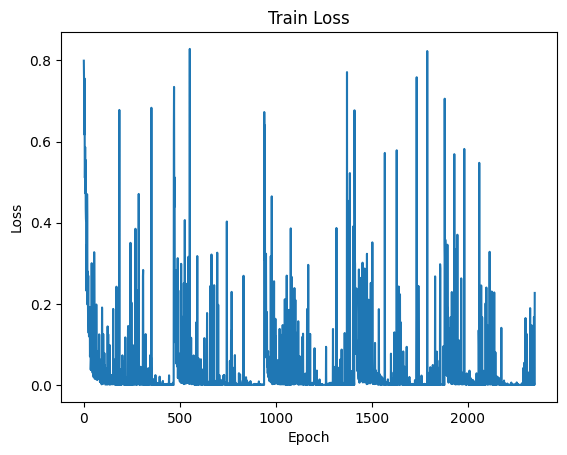

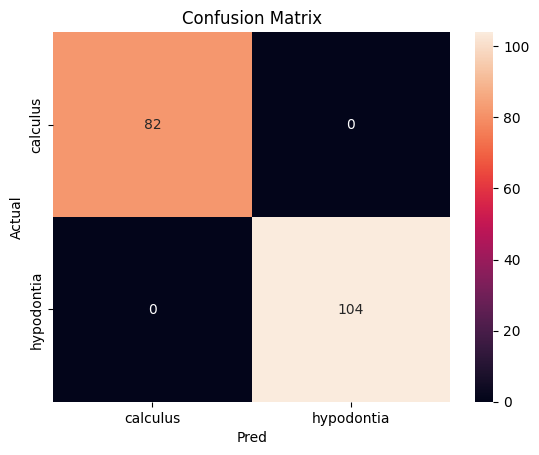

In [20]:
# 5-fold CV training & metrics
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

metrics = []   # list of (acc,prec,rec,f1,auc)
loss_hist = []

for fold,(ti,vi) in enumerate(kf.split(items,labels),1):
    tr=[items[i] for i in ti]; va=[items[i] for i in vi]
    cnt=np.bincount([l for _,l in tr])
    sampler=WeightedRandomSampler([1/cnt[l] for _,l in tr], len(tr), True)
    tr_ld = DataLoader(OralDS(tr,TRAIN_AUG), batch_size=16, sampler=sampler)
    va_ld = DataLoader(OralDS(va,VAL_AUG), batch_size=16, shuffle=False)

    model = HQCNN(2).to(device)
    weights = torch.tensor([cnt[1],cnt[0]], dtype=torch.float32, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    opt     = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=1e-3)
    sched   = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', 0.5, 2)

# train
    for epoch in range(10):
        model.train()
        for X,y in tr_ld:
            X,y = X.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step()
            loss_hist.append(loss.item())
        sched.step(loss.item())

    # eval
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for X,y in va_ld:
            X = X.to(device)
            logits = model(X)
            probs  = torch.softmax(logits,1)[:,1].cpu().numpy()
            y_true.extend(y.tolist())
            y_prob.extend(probs.tolist())

    y_pred = (np.array(y_prob)>0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true,y_pred,average='macro')
    rec  = recall_score(y_true, y_pred,average='macro')
    f1   = f1_score(y_true,y_pred,average='macro')
    auc  = roc_auc_score(y_true, y_prob)

    print(f"Fold{fold}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, AUROC={auc:.3f}")
    metrics.append((acc,prec,rec,f1,auc))

# averages
avg = np.mean(metrics,axis=0)
print(f"AVG → Acc={avg[0]:.3f}, Prec={avg[1]:.3f}, Rec={avg[2]:.3f}, F1={avg[3]:.3f}, AUROC={avg[4]:.3f}")

# 6) Visualization & interpretability

# a) ASCII quantum circuit
print(model.q_layer.qc.qc.draw(output='text'))

# b) Loss curve
plt.figure(); plt.plot(loss_hist); plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()

# c) Confusion matrix of last fold
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("Actual"); plt.show()

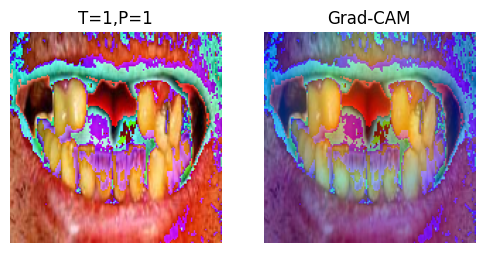

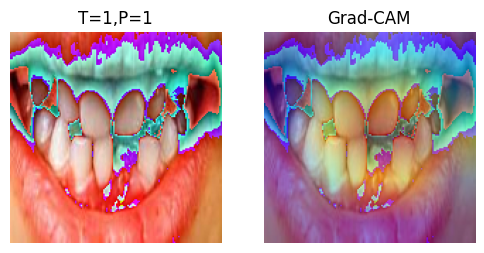

  0%|          | 0/100 [00:00<?, ?it/s]

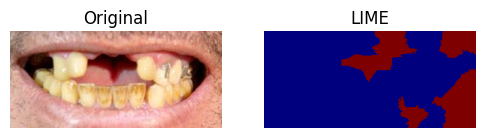

In [21]:
# d) Grad-CAM
cam = SmoothGradCAMpp(model, target_layer="backbone.layer4")
ds = OralDS(va, VAL_AUG)
for idx in [0,1]:
    img_t, true_lab = ds[idx]
    batch = img_t.unsqueeze(0).to(device)
    logits= model(batch)
    cls_i = logits.argmax(dim=1).item()
    cams  = cam(cls_i, logits)
    heat  = cams[0][0].cpu().numpy()
    # normalize & colormap
    hn    = (heat-heat.min())/(heat.max()-heat.min()+1e-8)
    hu    = np.uint8(255*hn)
    hc    = cv2.applyColorMap(hu, cv2.COLORMAP_JET)
    H,W   = img_t.shape[1], img_t.shape[2]
    hc    = cv2.resize(hc,(W,H))
    orig  = (img_t.permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    origb = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
    ovl   = cv2.addWeighted(hc, 0.4, origb, 0.6, 0)
    ovl   = cv2.cvtColor(ovl, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title(f"T={true_lab},P={cls_i}"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(ovl); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()

# e) LIME with requires_grad fix
explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    batch = torch.stack([VAL_AUG(image=i)['image'] for i in images]).to(device)
    batch.requires_grad_()  # enable gradient for hooks

    with torch.enable_grad():
        logits = model(batch)
        probs  = torch.softmax(logits, dim=1)

    # detach so numpy() works
    return probs.detach().cpu().numpy()

img_path, true_lab = va[0]
img = plt.imread(img_path)
exp = explainer.explain_instance(
    img, batch_predict, top_labels=1, num_samples=100
)
mask = exp.get_image_and_mask(
    exp.top_labels[0], positive_only=True,
    num_features=5, hide_rest=False
)[1]
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap="jet"); plt.title("LIME"); plt.axis("off")
plt.show()

